In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# BCE classifier

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn as nn
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,1),  nn.Sigmoid())
init_net(net)

In [ ]:
model = ModelWrapper(net)

data, test = get_paper_data(200000, bm=0, bs=32, n_test=1000000)

model.fit(200, data=data, opt=partialler(optim.SGD,lr=2e-3), loss=nn.BCELoss(),
          cbs=[LossTracker(),EarlyStopping(5)])

torch.save({'model':model.model.state_dict()}, 'weights/BCE_Test.h5')

In [ ]:
state = torch.load('weights/BCE_Test.h5', map_location='cpu')

In [ ]:
model.model.load_state_dict(state['model'])

<All keys matched successfully>

## BM 0

In [ ]:
preds = model.predict(test)

In [ ]:
preds

array([[7.8868276e-01],
       [8.6208284e-01],
       [7.6397753e-01],
       ...,
       [1.2600257e-06],
       [4.2732554e-03],
       [3.9683066e-05]], dtype=float32)

In [ ]:
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0.788683,1.0
1,0.862083,1.0
2,0.763978,1.0
3,0.606303,1.0
4,0.802604,1.0


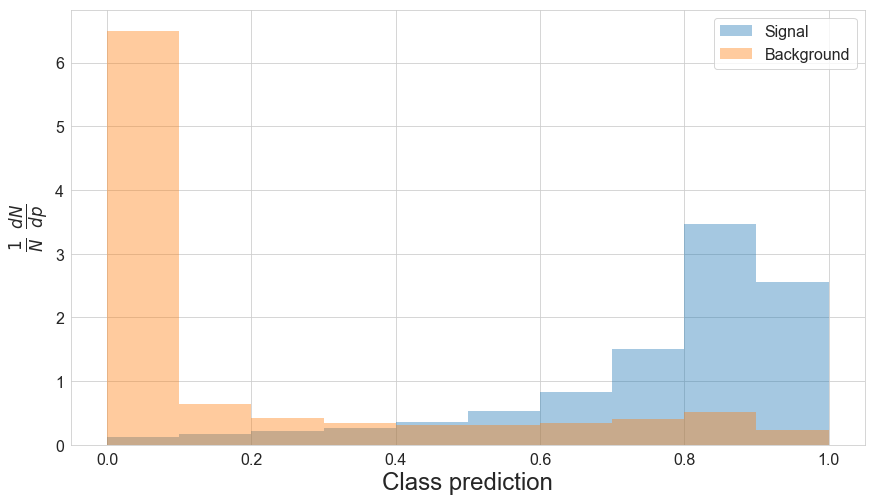

In [ ]:
plot_preds(df)

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,0.788683,1.0,7
1,0.862083,1.0,8
2,0.763978,1.0,7
3,0.606303,1.0,6
4,0.802604,1.0,8


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [ ]:
f_s, f_b

(tensor([0.0119, 0.0168, 0.0210, 0.0269, 0.0359, 0.0526, 0.0825, 0.1500, 0.3464,
         0.2561]),
 tensor([0.6503, 0.0633, 0.0417, 0.0337, 0.0309, 0.0310, 0.0343, 0.0400, 0.0521,
         0.0227]))

In [ ]:
t_exp = (50*f_s)+(1000*f_b)

In [ ]:
t_exp, t_exp.sum()

(tensor([650.8745,  64.1344,  42.7101,  35.0765,  32.6490,  33.6738,  38.3916,
          47.5221,  69.4405,  35.5275]), tensor(1049.9999))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+((n-m)*f_b))
    y[i] = -pois.log_prob(t_exp).sum()
y -= y.min()

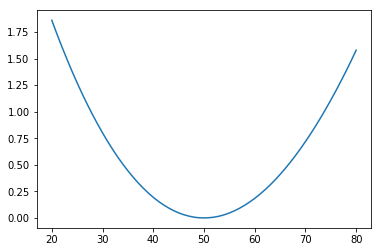

In [ ]:
plt.plot(x,y)

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [ ]:
r = InterpolatedUnivariateSpline(x, y-0.5).roots()

In [ ]:
(r[1]-r[0])/2

16.25969108942605

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model)

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0.788683,1.0,7,0.788683,7,0.788683,7,7.886828e-01,7,0.788683,7,0.788683,7
1,0.862083,1.0,8,0.862083,8,0.862083,8,8.620828e-01,8,0.862083,8,0.862083,8
2,0.763978,1.0,7,0.763978,7,0.763978,7,7.639775e-01,7,0.763978,7,0.763978,7
3,0.606303,1.0,6,0.606303,6,0.606303,6,6.063033e-01,6,0.606303,6,0.606303,6
4,0.802604,1.0,8,0.802604,8,0.802604,8,8.026036e-01,8,0.802604,8,0.802604,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.010828,0.0,0,0.014899,0,0.010828,0,7.031421e-03,0,0.010942,0,0.010517,0
999996,0.000049,0.0,0,0.000079,0,0.000049,0,3.041509e-05,0,0.000060,0,0.000041,0
999997,0.000001,0.0,0,0.000002,0,0.000001,0,9.735454e-07,0,0.000001,0,0.000001,0
999998,0.004273,0.0,0,0.004537,0,0.004273,0,4.084028e-03,0,0.005692,0,0.003919,0


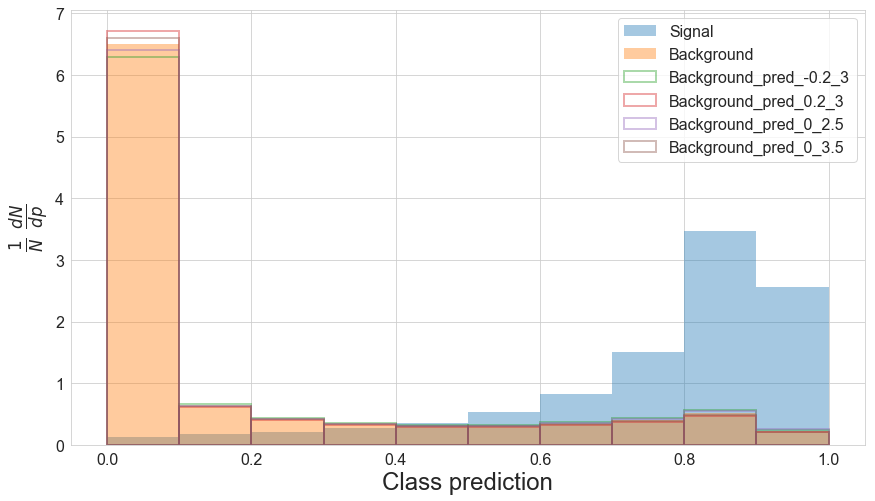

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'])

In [ ]:
def interp_shape(alpha:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor):
    alpha_t = torch.repeat_interleave(alpha.unsqueeze(-1), repeats=f_b_nom.shape[0], dim=-1)
    a = 0.5 * (f_b_up + f_b_dw) - f_b_nom
    b = 0.5 * (f_b_up - f_b_dw)

    switch = torch.where(alpha_t < 0., f_b_dw - f_b_nom, f_b_up - f_b_nom)
    abs_var = torch.where(torch.abs(alpha_t) > 1.,
                          (2 * b + torch.sign(alpha_t) * a) *
                          (alpha_t - torch.sign(alpha_t)) + switch,
                          a*torch.pow(alpha_t, 2)+ b * alpha_t)
#     abs_var = a*torch.pow(alpha_t, 2)+ b * alpha_t
    c =  f_b_nom + abs_var.sum(1)
    return c/c.sum()

In [ ]:
interp_shape(Tensor((0,0))[None,:], **b_shapes).sum()

tensor(1.)

In [ ]:
b_shapes['f_b_nom'][i].data.item()

0.6502779722213745

In [ ]:
interp_shape(Tensor((-1,0))[None,:], **b_shapes)

tensor([[0.6287, 0.0659, 0.0434, 0.0354, 0.0328, 0.0328, 0.0366, 0.0431, 0.0565,
         0.0248]])

In [ ]:
b_shapes['f_b_dw'][1]

tensor([0.6411, 0.0633, 0.0419, 0.0337, 0.0312, 0.0312, 0.0351, 0.0413, 0.0555,
        0.0258])

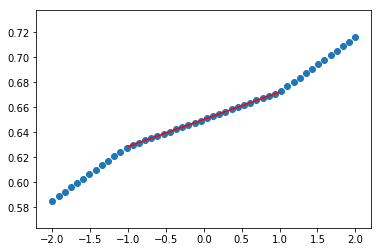

In [ ]:
i = 0
d = b_shapes['f_b_dw'][0][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][0][i]
interp = []
rs = np.linspace(-2,2)
for r in rs: interp.append(interp_shape(Tensor((r,0))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(rs, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

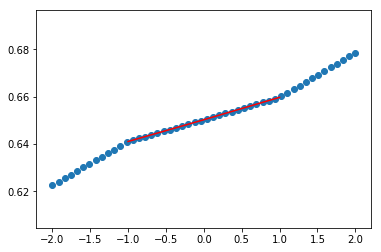

In [ ]:
i = 0
d = b_shapes['f_b_dw'][1][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][1][i]
interp = []
ls = np.linspace(-2,2)
for l in ls: interp.append(interp_shape(Tensor((0,l))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(ls, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

In [ ]:
b_shapes['f_b_nom']

tensor([0.6503, 0.0633, 0.0417, 0.0337, 0.0309, 0.0310, 0.0343, 0.0400, 0.0521,
        0.0227])

In [ ]:
alpha = Tensor((1,0))[None,:]
interp_shape(alpha, **b_shapes).squeeze()

tensor([0.6722, 0.0611, 0.0396, 0.0318, 0.0289, 0.0293, 0.0316, 0.0375, 0.0474,
        0.0205])

In [ ]:
b_shapes['f_b_up']

tensor([[0.6722, 0.0611, 0.0396, 0.0318, 0.0289, 0.0293, 0.0316, 0.0375, 0.0474,
         0.0205],
        [0.6598, 0.0631, 0.0415, 0.0334, 0.0305, 0.0305, 0.0334, 0.0389, 0.0488,
         0.0202]])

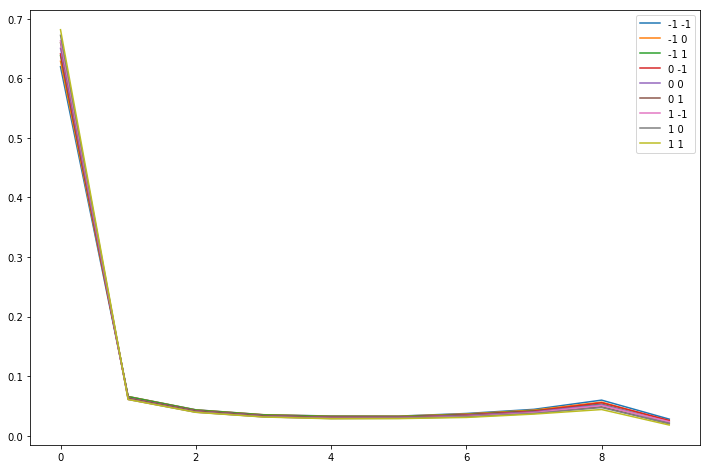

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        plt.plot(s, label=f'{r} {l}')
plt.legend()

In [ ]:
nll = likelihood_from_updw(f_s=f_s, **b_shapes)

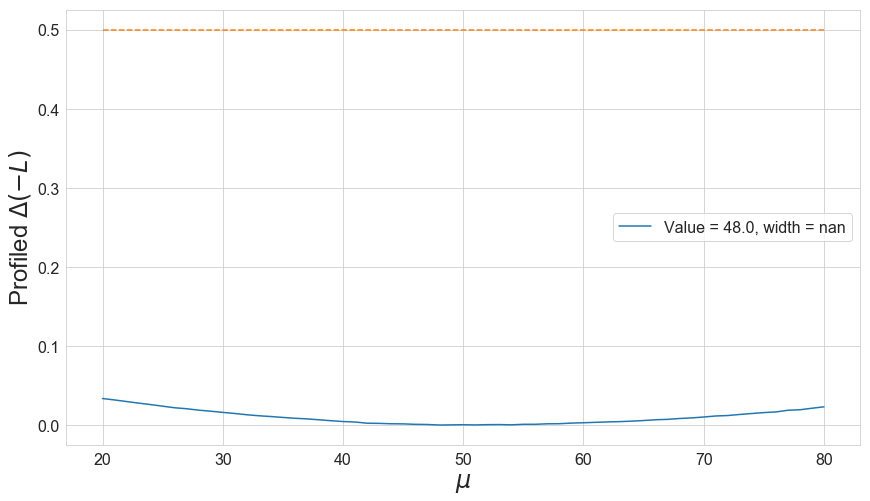

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1

In [ ]:
b_shapes['f_b_dw'] = b_shapes['f_b_dw'][0]
b_shapes['f_b_up'] = b_shapes['f_b_up'][0]

In [ ]:
nll = likelihood_from_updw(f_s=f_s, **b_shapes)

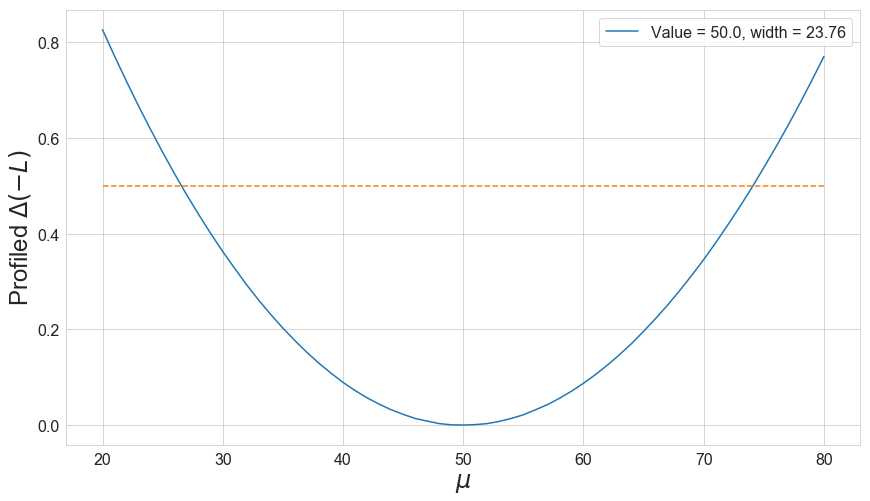

In [ ]:
plot_likelihood(nll-nll.min())